In [1]:
from google.colab import auth
auth.authenticate_user()

import pandas as pd
from google.cloud import bigquery

project_id = "bis638proj"
dataset_id = "Final_proj"

client = bigquery.Client(project=project_id)


In [2]:
query = """
SELECT *
FROM `bis638proj.Final_proj.cleaned_data`
"""
df = client.query(query).to_dataframe()
df.shape

(5297, 148)

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, classification_report

In [4]:
target = "hospital_expire_flag"

# Columns we don't want to use as features
id_cols = [
    "subject_id", "hadm_id", "stay_id",
    "Group_Name", "Term", "DOID", "ICD10Code"
]

time_cols = [
    "dod", "admittime", "dischtime",
    "icu_intime", "icu_outtime",
    "admittime_1", "dischtime_1", "deathtime", "dod_1"
]

leak_cols = ["los_hospital", "los_icu"]

drop_cols = id_cols + time_cols + leak_cols + [target]


X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target]

# Make sure bools are numeric (0/1)
bool_cols = X.select_dtypes("bool").columns
X[bool_cols] = X[bool_cols].astype(int)

# Identify numeric and categorical feature columns
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(cat_cols))

Numeric cols: 125
Categorical cols: 7


In [5]:
X.isna().sum().sum()


np.int64(0)

In [6]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

subjects = df["subject_id"].to_numpy()
rng = np.random.default_rng(638)
rng.shuffle(subjects)

n_train_subj = int(0.8 * len(subjects))
train_subj = subjects[:n_train_subj]

train_mask = df["subject_id"].isin(train_subj)
test_mask  = ~train_mask

X_train = X.loc[train_mask].copy()
X_test  = X.loc[test_mask].copy()
y_train = y.loc[train_mask].copy()
y_test  = y.loc[test_mask].copy()

print("unique subj train:", df.loc[train_mask, "subject_id"].nunique(),
      "unique subj test:", df.loc[test_mask, "subject_id"].nunique())
print("rows train:", len(X_train), "rows test:", len(X_test))


unique subj train: 1852 unique subj test: 113
rows train: 5131 rows test: 166


In [7]:
logit_cv = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l1",
    solver="liblinear",
    scoring="roc_auc",
    max_iter=5000,
    n_jobs=-1,
    refit=True
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", logit_cv)
])

clf.fit(X_train, y_train)

y_proba_logit = clf.predict_proba(X_test)[:, 1]   # P(death)
y_pred_logit  = clf.predict(X_test)               # 0/1 prediction

print("Test AUC:", roc_auc_score(y_test, y_proba_logit))
print(classification_report(y_test, y_pred_logit))


Test AUC: 0.7612212349054455
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.88       133
         1.0       0.33      0.09      0.14        33

    accuracy                           0.78       166
   macro avg       0.57      0.52      0.51       166
weighted avg       0.71      0.78      0.73       166



In [8]:
preprocess = clf.named_steps["preprocess"]
logit_cv   = clf.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

coefs = logit_cv.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})
coef_df["abs_coef"] = coef_df["coef"].abs()

nonzero_coef_df = coef_df[coef_df["coef"] != 0].copy()

top_k = 20
top_features = nonzero_coef_df.sort_values("abs_coef", ascending=False).head(top_k)

#print(top_features)

In [9]:
def adjust_feature_name(raw: str) -> str:
    """
    Turn names like 'num__anchor_age' or 'cat__gender_F'
    into 'anchor_age' or 'gender = F'.
    """
    if "__" in raw:
        prefix, rest = raw.split("__", 1)
    else:
        rest = raw

    if "_" in rest:
        base, level = rest.split("_", 1)
        if prefix == "cat":
            return f"{base} = {level}"
        else:
            return rest
    else:
        return rest

top_k = 20
top_features = (
    nonzero_coef_df
    .sort_values("abs_coef", ascending=False)
    .head(top_k)
    .copy()
)

top_features["feature_name"] = top_features["feature"].apply(adjust_feature_name)
top_features


,feature,coef,abs_coef,feature_name
0,num__admission_age,0.322326,0.322326,admission_age
119,num__urineoutput,-0.269266,0.269266,urineoutput
11,num__platelets_min,-0.221392,0.221392,platelets_min
48,num__fibrinogen_max,-0.207446,0.207446,fibrinogen_max
86,num__temperature_mean,-0.194657,0.194657,temperature_mean
13,num__wbc_min,0.176256,0.176256,wbc_min
67,num__ld_ldh_min,0.164840,0.164840,ld_ldh_min
70,num__heart_rate_max,0.164097,0.164097,heart_rate_max
95,num__ph_min,-0.137479,0.137479,ph_min
21,num__bun_min,0.136691,0.136691,bun_min


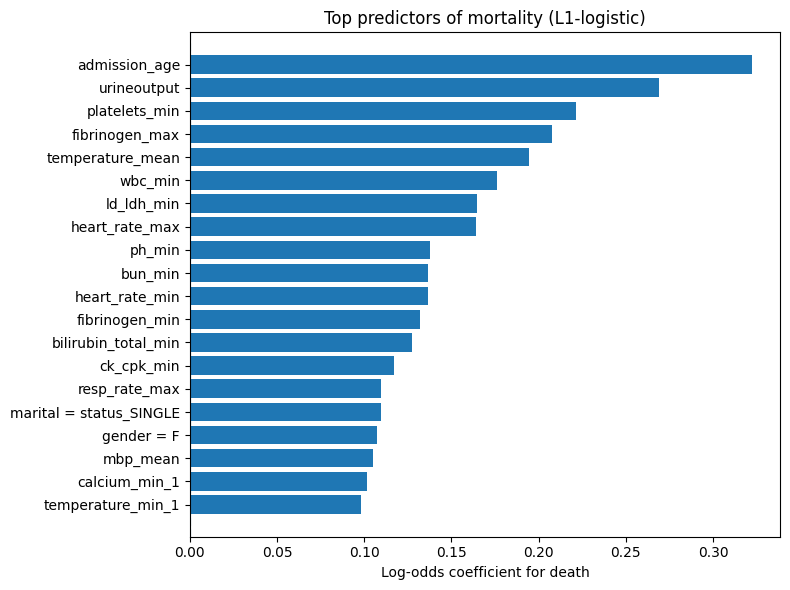

In [10]:
import matplotlib.pyplot as plt

plot_df = top_features.sort_values("abs_coef")

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature_name"], plot_df["abs_coef"])
plt.axvline(0, linestyle="--")
plt.xlabel("Log-odds coefficient for death")
plt.title("Top predictors of mortality (L1-logistic)")
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report

from xgboost import XGBClassifier

In [12]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

clf_xgb = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_model)
])

clf_xgb.fit(X_train, y_train)

y_proba_xgb = clf_xgb.predict_proba(X_test)[:, 1]  # predicted P(death)
y_pred_xgb  = clf_xgb.predict(X_test)              # 0/1 prediction

print("XGBoost Test AUC:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Test AUC: 0.9273182957393484
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       133
         1.0       0.81      0.52      0.63        33

    accuracy                           0.88       166
   macro avg       0.85      0.74      0.78       166
weighted avg       0.87      0.88      0.87       166



In [13]:
preprocess = clf_xgb.named_steps["preprocess"]
xgb_model  = clf_xgb.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

fi_df = fi_df.sort_values("importance", ascending=False)

top_k = 20
top_importances = fi_df.head(top_k)
#print(top_importances)

In [14]:
fi_df["feature_name"] = fi_df["feature"].apply(adjust_feature_name)
top_importances = fi_df.head(top_k)
print(top_importances[["feature_name", "importance"]])


                 feature_name  importance
94                lactate_max    0.029110
61        bilirubin_total_min    0.023835
111         temperature_min_1    0.018074
107            baseexcess_min    0.018044
93                lactate_min    0.014592
119               urineoutput    0.014373
179  marital = status_MARRIED    0.014046
62        bilirubin_total_max    0.013929
0               admission_age    0.013084
89                  spo2_mean    0.012450
21                    bun_min    0.011251
22                    bun_max    0.011022
70             heart_rate_max    0.010607
80                   mbp_mean    0.010555
46       imm_granulocytes_max    0.010434
49                    inr_min    0.010415
16                albumin_max    0.010147
71            heart_rate_mean    0.010104
180   marital = status_SINGLE    0.010036
5                  anchor_age    0.010013


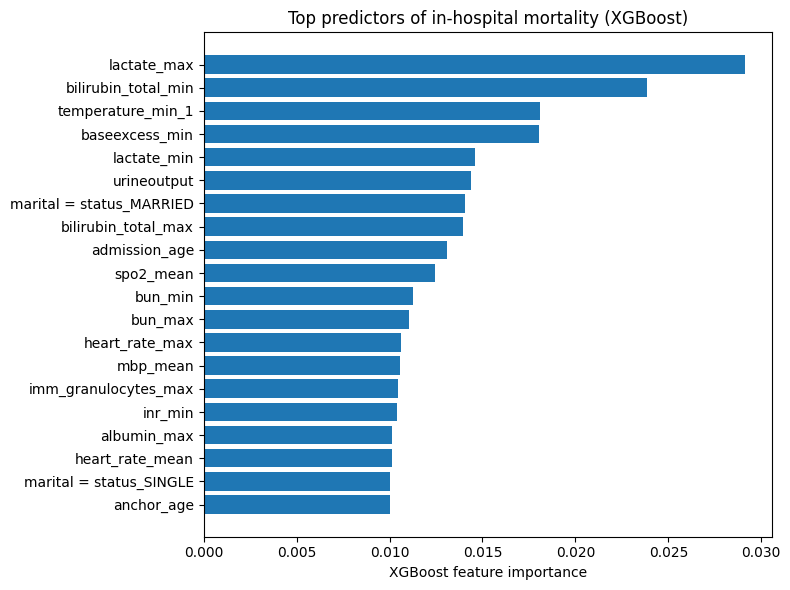

In [15]:
import matplotlib.pyplot as plt

plot_df = top_importances.sort_values("importance")

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature_name"], plot_df["importance"])
plt.xlabel("XGBoost feature importance")
plt.title("Top predictors of in-hospital mortality (XGBoost)")
plt.tight_layout()
plt.show()


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

clf_rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

clf_rf.fit(X_train, y_train)

y_proba_rf = clf_rf.predict_proba(X_test)[:, 1]   # P(death)
y_pred_rf  = clf_rf.predict(X_test)               # 0/1 prediction

print("Random Forest Test AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Test AUC: 0.9808612440191388
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       133
         1.0       1.00      0.91      0.95        33

    accuracy                           0.98       166
   macro avg       0.99      0.95      0.97       166
weighted avg       0.98      0.98      0.98       166



In [17]:
pre = clf_rf.named_steps["preprocess"]
rf_model = clf_rf.named_steps["model"]

feat_names = pre.get_feature_names_out()
importances = rf_model.feature_importances_

fi_rf = pd.DataFrame({
    "feature": feat_names,
    "importance": importances
}).sort_values("importance", ascending=False)

#fi_rf.head(20)

In [18]:
fi_rf["feature_name"] = fi_rf["feature"].apply(adjust_feature_name)
top_importances_rf = fi_rf.head(top_k)
top_importances_rf[["feature_name","importance"]]

,feature_name,importance
119,urineoutput,0.024577
5,anchor_age,0.018571
0,admission_age,0.017737
11,platelets_min,0.014766
22,bun_max,0.014600
71,heart_rate_mean,0.014383
94,lactate_max,0.014004
86,temperature_mean,0.013994
93,lactate_min,0.013056
54,ptt_max,0.012943


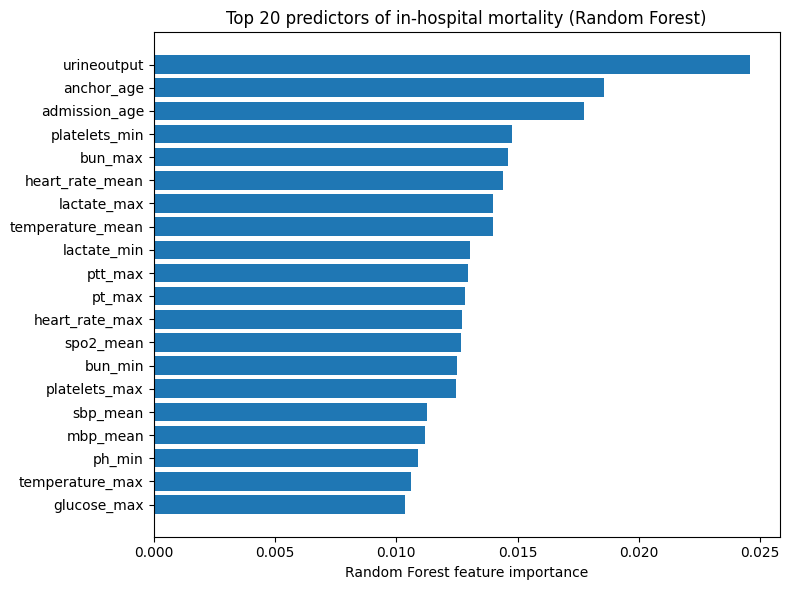

In [19]:
plot_df = top_importances_rf.sort_values("importance")

plt.figure(figsize=(8, 6))
plt.barh(plot_df["feature_name"], plot_df["importance"])
plt.xlabel("Random Forest feature importance")
plt.title("Top 20 predictors of in-hospital mortality (Random Forest)")
plt.tight_layout()
plt.savefig("rf_predictors.png", dpi=300, bbox_inches="tight")
plt.show()

1. Model comparison

In [20]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score
)
import pandas as pd

# 1) Logistic
y_proba_logit = clf.predict_proba(X_test)[:, 1]
y_pred_logit  = clf.predict(X_test)

# 2) Random Forest
y_proba_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf  = clf_rf.predict(X_test)

# 3) XGBoost
y_proba_xgb = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb  = clf_xgb.predict(X_test)

results = []

def add_row(name, y_true, y_proba, y_pred):
    results.append({
        "Model": name,
        "AUC": roc_auc_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall_death": recall_score(y_true, y_pred, pos_label=1),
        "Precision_death": precision_score(y_true, y_pred, pos_label=1),
    })

add_row("Logistic (L1)", y_test, y_proba_logit, y_pred_logit)
add_row("XGBoost",       y_test, y_proba_xgb,  y_pred_xgb)
add_row("Random Forest", y_test, y_proba_rf,    y_pred_rf)

metrics_df = pd.DataFrame(results)
metrics_df = metrics_df.round(3)
print(metrics_df)

           Model    AUC  Accuracy  Recall_death  Precision_death
0  Logistic (L1)  0.761     0.783         0.091            0.333
1        XGBoost  0.927     0.880         0.515            0.810
2  Random Forest  0.981     0.982         0.909            1.000


2. ROC & Precision–Recall curves on one plot

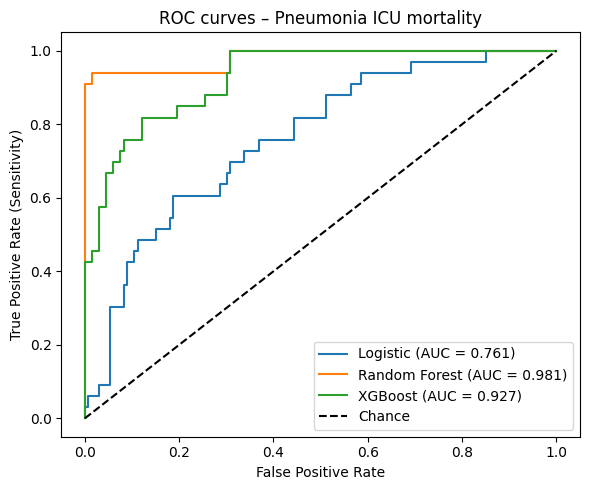

In [21]:
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# predicted probabilities (P(death = 1))
y_proba_logit = clf.predict_proba(X_test)[:, 1]
y_proba_rf    = clf_rf.predict_proba(X_test)[:, 1]
y_proba_xgb   = clf_xgb.predict_proba(X_test)[:, 1]

plt.figure(figsize=(6, 5))

# Logistic
fpr_l, tpr_l, _ = roc_curve(y_test, y_proba_logit)
auc_l = roc_auc_score(y_test, y_proba_logit)
plt.plot(fpr_l, tpr_l, label=f"Logistic (AUC = {auc_l:.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")

# XGBoost
fpr_x, tpr_x, _ = roc_curve(y_test, y_proba_xgb)
auc_x = roc_auc_score(y_test, y_proba_xgb)
plt.plot(fpr_x, tpr_x, label=f"XGBoost (AUC = {auc_x:.3f})")

# chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC curves – Pneumonia ICU mortality")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


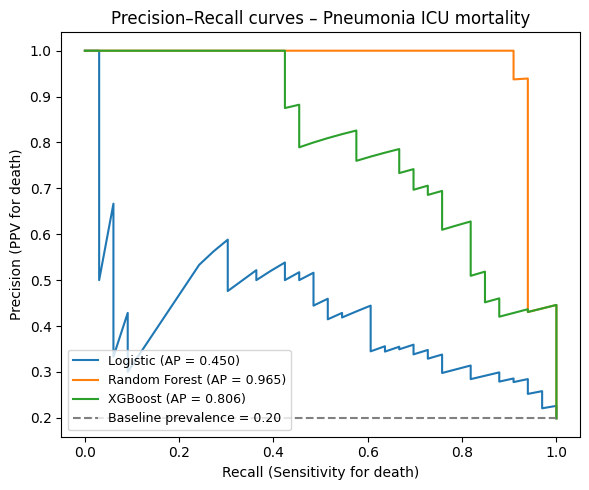

In [22]:
plt.figure(figsize=(6, 5))

# Logistic
prec_l, rec_l, _ = precision_recall_curve(y_test, y_proba_logit)
ap_l = average_precision_score(y_test, y_proba_logit)
plt.plot(rec_l, prec_l, label=f"Logistic (AP = {ap_l:.3f})")

# Random Forest
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
ap_rf = average_precision_score(y_test, y_proba_rf)
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP = {ap_rf:.3f})")

# XGBoost
prec_x, rec_x, _ = precision_recall_curve(y_test, y_proba_xgb)
ap_x = average_precision_score(y_test, y_proba_xgb)
plt.plot(rec_x, prec_x, label=f"XGBoost (AP = {ap_x:.3f})")

# baseline = prevalence of death
base = y_test.mean()
plt.hlines(base, 0, 1, colors="gray", linestyles="dashed",
           label=f"Baseline prevalence = {base:.2f}")

plt.xlabel("Recall (Sensitivity for death)")
plt.ylabel("Precision (PPV for death)")
plt.title("Precision–Recall curves – Pneumonia ICU mortality")
plt.legend(
    loc="lower left",
    frameon=True,
    fontsize=9
)
plt.tight_layout()
plt.tight_layout()
plt.show()


3. Threshold tuning: show how we trade off missing deaths vs false alarms

In [23]:
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix
)

thresholds = [0.2, 0.4, 0.5, 0.6, 0.8]

rows = []
for thr in thresholds:
    y_pred_thr = (y_proba_rf >= thr).astype(int)  # 1 = predict death

    prec = precision_score(y_test, y_pred_thr, pos_label=1)
    rec  = recall_score(y_test, y_pred_thr,   pos_label=1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thr).ravel()
    specificity = tn / (tn + fp)   # true negative rate

    rows.append({
        "Threshold": thr,
        "Recall_death": rec,
        "Precision_death": prec,
        "Specificity_survival": specificity,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

thresh_df = pd.DataFrame(rows).round(3)
print(thresh_df)


   Threshold  Recall_death  Precision_death  Specificity_survival  TP  FP  FN  \
0        0.2         0.939            0.689                 0.895  31  14   2   
1        0.4         0.909            0.938                 0.985  30   2   3   
2        0.5         0.909            1.000                 1.000  30   0   3   
3        0.6         0.909            1.000                 1.000  30   0   3   
4        0.8         0.394            1.000                 1.000  13   0  20   

    TN  
0  119  
1  131  
2  133  
3  133  
4  133  


4. Compare feature importance across models

In [24]:
pre = clf.named_steps["preprocess"]

num_feature_names = np.array(numeric_cols)

ohe = pre.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_feature_names, cat_feature_names])


In [25]:
def aggregate_importance(feature_names, importances):
    """
    feature_names: array of transformed feature names
    importances:   array of importance values (same length)

    Returns a DataFrame with importance summed per original feature.
    """
    base_names = []
    for name in feature_names:
        if name in numeric_cols:
            base_names.append(name)
        else:
            # one-hot names look like "race_Black", "gender_F"
            base_names.append(name.split("_", 1)[0])

    df_imp = pd.DataFrame({
        "feature": base_names,
        "importance": importances
    })

    agg = (
        df_imp.groupby("feature", as_index=False)["importance"]
              .sum()
              .sort_values("importance", ascending=False)
    )
    return agg


In [26]:
# Logistic
logit = clf.named_steps["model"]
coef = logit.coef_.ravel()            # shape (n_features,)
imp_logit = aggregate_importance(feature_names, np.abs(coef))


In [27]:
# XGBoost
xgb = clf_xgb.named_steps["model"]
imp_xgb = aggregate_importance(feature_names, xgb.feature_importances_)


In [28]:
# Random forest
rf = clf_rf.named_steps["model"]
imp_rf = aggregate_importance(feature_names, rf.feature_importances_)


In [29]:
TOP_K = 20

top_feat = (
    set(imp_logit.head(TOP_K)["feature"]) |
    set(imp_rf.head(TOP_K)["feature"])     |
    set(imp_xgb.head(TOP_K)["feature"])
)

combined = pd.DataFrame(index=sorted(top_feat))
combined["Logistic_L1"] = combined.index.map(
    dict(zip(imp_logit["feature"], imp_logit["importance"]))
)
combined["RandomForest"] = combined.index.map(
    dict(zip(imp_rf["feature"], imp_rf["importance"]))
)
combined["XGBoost"] = combined.index.map(
    dict(zip(imp_xgb["feature"], imp_xgb["importance"]))
)

combined = combined.fillna(0)

# normalize each model’s column so max = 1 (easier to compare)
combined_norm = combined.divide(combined.max())

print(combined_norm.round(3))


                      Logistic_L1  RandomForest  XGBoost
admission                   0.237         0.384    1.000
admission_age               1.000         0.722    0.361
albumin_max                 0.161         0.282    0.280
anchor_age                  0.000         0.756    0.277
baseexcess_min              0.000         0.395    0.498
bilirubin_total_max         0.152         0.404    0.385
bilirubin_total_min         0.396         0.325    0.658
bun_max                     0.000         0.594    0.304
bun_min                     0.424         0.509    0.311
calcium_min_1               0.315         0.167    0.174
ck_cpk_min                  0.362         0.196    0.221
fibrinogen_max              0.644         0.155    0.204
fibrinogen_min              0.410         0.129    0.154
gender                      0.334         0.111    0.321
glucose_max                 0.153         0.422    0.244
heart_rate_max              0.509         0.517    0.293
heart_rate_mean             0.0

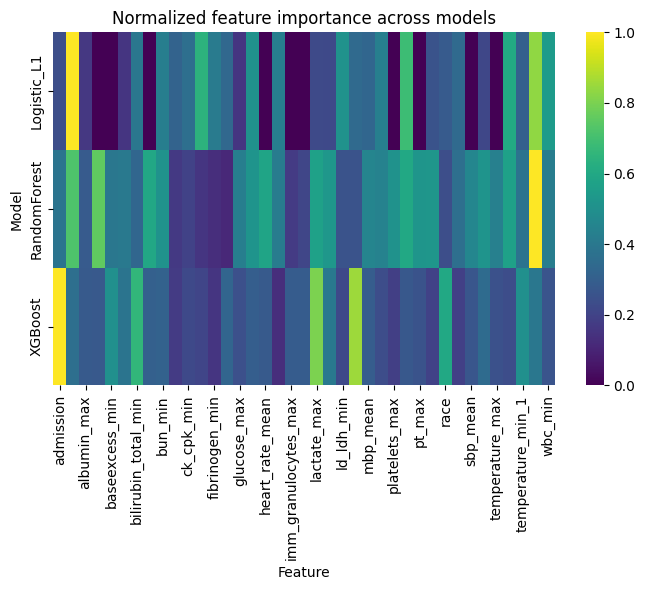

In [30]:
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.heatmap(combined_norm.T, annot=False, cmap="viridis")
plt.xlabel("Feature")
plt.ylabel("Model")
plt.title("Normalized feature importance across models")
plt.tight_layout()
plt.show()


In [31]:
TOP_K = 20

# 1) features that ever appear in top-K of any model
top_features = (
    set(imp_logit.nlargest(TOP_K, "importance")["feature"]) |
    set(imp_rf.nlargest(TOP_K, "importance")["feature"])     |
    set(imp_xgb.nlargest(TOP_K, "importance")["feature"])
)
top_features = sorted(top_features)

def selected_from_imp(imp_df, thresh_ratio=0.15):
    """Return a set of features whose importance is ≥ thresh_ratio * max."""
    max_imp = imp_df["importance"].max()
    cutoff = thresh_ratio * max_imp
    return set(imp_df.loc[imp_df["importance"] >= cutoff, "feature"])

sel_L   = selected_from_imp(imp_logit, thresh_ratio=0.15)
sel_RF  = selected_from_imp(imp_rf,    thresh_ratio=0.15)
sel_XGB = selected_from_imp(imp_xgb,   thresh_ratio=0.15)

presence = pd.DataFrame({
    "Feature": top_features,
    "L_logit": [f in sel_L   for f in top_features],
    "RF":      [f in sel_RF  for f in top_features],
    "XGB":     [f in sel_XGB for f in top_features],
})

print(presence.head())


          Feature  L_logit    RF   XGB
0       admission     True  True  True
1   admission_age     True  True  True
2     albumin_max     True  True  True
3      anchor_age    False  True  True
4  baseexcess_min    False  True  True


In [32]:
def dot(b, ch_filled, ch_empty="○"):
    return ch_filled if b else ch_empty

presence["Markers"] = [
    f"{dot(L,  '🔵')} {dot(RF, '🟠')} {dot(XGB,'🟢')}"
    for L, RF, XGB in zip(presence["L_logit"], presence["RF"], presence["XGB"])
]

presence_display = presence[["Feature", "Markers"]]
#print(presence_display.to_string(index=False))


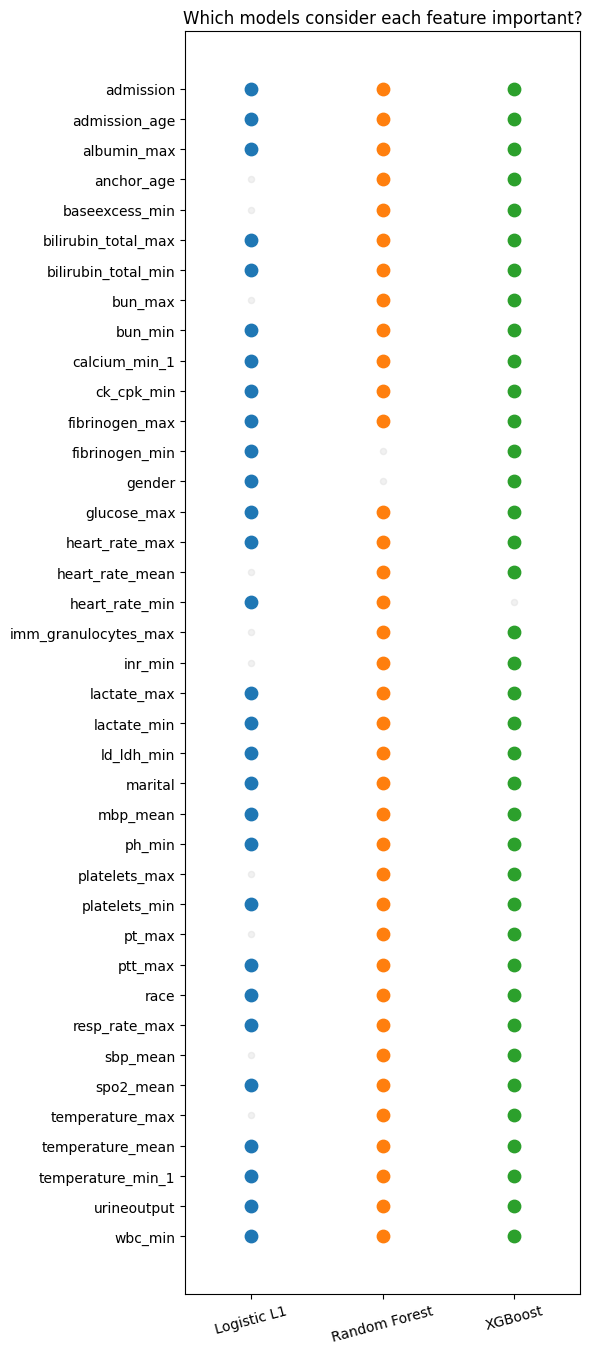

In [33]:
import matplotlib.pyplot as plt

models = ["Logistic L1", "Random Forest", "XGBoost"]
model_keys = ["L_logit", "RF", "XGB"]
colors = {"L_logit": "tab:blue", "RF": "tab:orange", "XGB": "tab:green"}

fig, ax = plt.subplots(figsize=(6, 0.35 * len(top_features)))

for i, feat in enumerate(top_features):
    for j, key in enumerate(model_keys):
        selected = presence.loc[i, key]
        if selected:
            ax.scatter(j, i, s=80, color=colors[key])
        else:
            ax.scatter(j, i, s=20, color="lightgray", alpha=0.3)

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=15)
ax.invert_yaxis()
ax.set_xlim(-0.5, len(models)-0.5)
ax.set_title("Which models consider each feature important?")
plt.tight_layout()
plt.show()


In [34]:
query = """
SELECT *
FROM `bis638proj.Final_proj.pip_table`
"""
pip = client.query(query).to_dataframe()
pip

,index,feature,PIP
0,2,first_hosp_stay,1.000000
1,119,urineoutput,1.000000
2,70,heart_rate_max,0.986292
3,112,temperature_max_1,0.877833
4,111,temperature_min_1,0.876958
5,140,race_HISPANIC/LATINO - HONDURAN,0.840458
6,86,temperature_mean,0.793833
7,16,albumin_max,0.709417
8,62,bilirubin_total_max,0.689750
9,65,ck_mb_min,0.612125


In [35]:
def aggregate_pip_race(pip_df):
    """
    Aggregate Bayesian PIP by collapsing all race_* features into one 'race'.
    Everything else keeps its own name.
    """
    base_names = []
    for name in pip_df["feature"]:
        if name.startswith("race_"):
            base_names.append("race")
        else:
            base_names.append(name)

    df_imp = pd.DataFrame({
        "feature": base_names,
        "PIP": pip_df["PIP"].values
    })

    agg = (
        df_imp.groupby("feature", as_index=False)["PIP"]
              .mean()
              .sort_values("PIP", ascending=False)
    )
    return agg

pip_agg = aggregate_pip_race(pip)
print(pip_agg.head())


              feature       PIP
5     first_hosp_stay  1.000000
12        urineoutput  1.000000
6      heart_rate_max  0.986292
9   temperature_max_1  0.877833
11  temperature_min_1  0.876958


In [36]:
sel_Bayes = set(
    pip["feature"])
TOP_K = 15

# Features that ever appear in top-K of RF or XGB or in Bayesian selected set
top_features = (
    set(imp_rf.nlargest(TOP_K, "importance")["feature"])
    | set(imp_xgb.nlargest(TOP_K, "importance")["feature"])
    | sel_Bayes
)
top_features = sorted(top_features)

def selected_from_imp(imp_df, thresh_ratio=0.15):
    max_imp = imp_df["importance"].max()
    cutoff = thresh_ratio * max_imp
    return set(imp_df.loc[imp_df["importance"] >= cutoff, "feature"])

sel_RF  = selected_from_imp(imp_rf,    thresh_ratio=0.15)
sel_XGB = selected_from_imp(imp_xgb,   thresh_ratio=0.15)

presence = pd.DataFrame({"Feature": top_features})
presence["Bayes"] = presence["Feature"].isin(sel_Bayes)
presence["RF"]    = presence["Feature"].isin(sel_RF)
presence["XGB"]   = presence["Feature"].isin(sel_XGB)

print(presence.head())


                                             Feature  Bayes     RF    XGB
0                                          admission  False   True   True
1                                      admission_age   True   True   True
2  admission_location_INTERNAL TRANSFER TO OR FRO...   True  False  False
3                                        albumin_max   True   True   True
4                                         anchor_age  False   True   True


In [37]:
def dot(b, ch_filled, ch_empty="○"):
    return ch_filled if b else ch_empty

presence["Markers"] = [
    f"{dot(b, '🔵')} {dot(r, '🟠')} {dot(x, '🟢')}"
    for b, r, x in zip(presence["Bayes"], presence["RF"], presence["XGB"])
]

presence_display = presence[["Feature", "Markers"]]


/tmp/ipython-input-1006695753.py:29: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


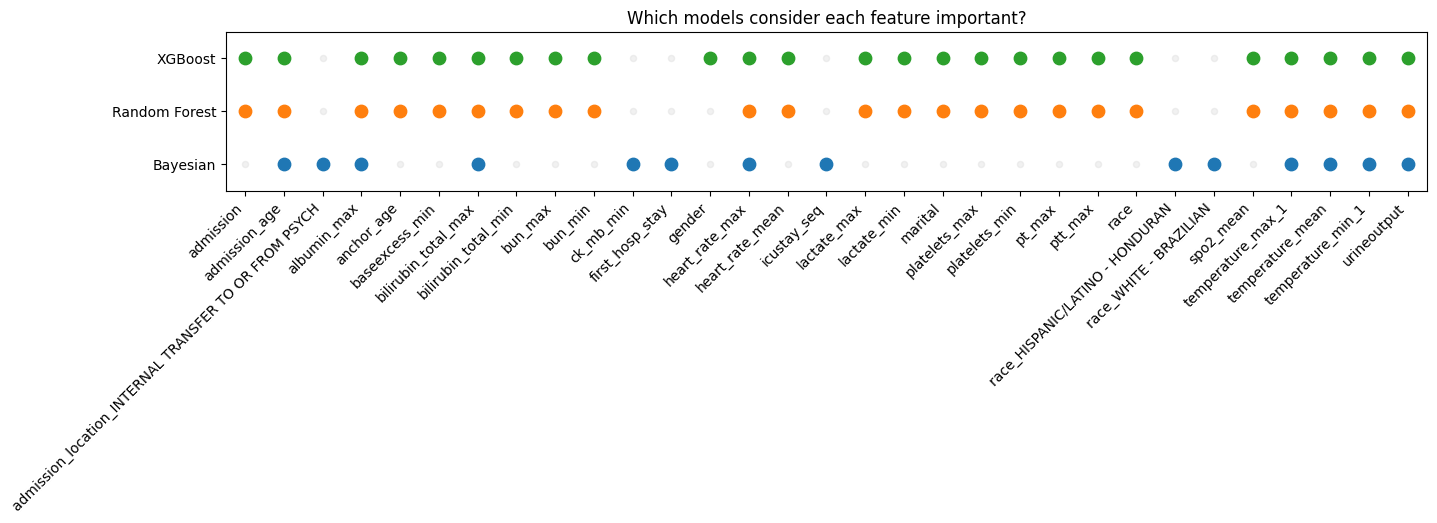

In [38]:
import matplotlib.pyplot as plt

models     = ["Bayesian", "Random Forest", "XGBoost"]
model_keys = ["Bayes", "RF", "XGB"]
colors     = {"Bayes": "tab:blue", "RF": "tab:orange", "XGB": "tab:green"}

fig, ax = plt.subplots(figsize=(0.5 * len(top_features), 3))

for i, feat in enumerate(top_features):
    row = presence.iloc[i]
    for j, key in enumerate(model_keys):
        selected = row[key]
        if selected:
            ax.scatter(i, j, s=80, color=colors[key])
        else:
            ax.scatter(i, j, s=20, color="lightgray", alpha=0.3)

# Axes labels & ticks
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=45, ha="right")
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)

ax.set_xlim(-0.5, len(top_features) - 0.5)
ax.set_ylim(-0.5, len(models) - 0.5)

ax.set_title("Which models consider each feature important?")

plt.tight_layout()
fig.subplots_adjust(bottom=0.35)
plt.show()


In [39]:
fig.savefig("feature_overlap.png", dpi=300, bbox_inches="tight")

5. Subgroup performance

In [40]:
age_test    = df.loc[test_mask, "admission_age"]
gender_test = df.loc[test_mask, "gender"]

# Age subgroups
young_mask = age_test < 65
old_mask   = age_test >= 65

# Gender subgroups
male_mask   = gender_test == "M"
female_mask = gender_test == "F"

In [41]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

def subgroup_metrics(mask, name):
    # 1. Filter to the subgroup
    y_true = y_test[mask]
    y_prob = y_proba_rf[mask]
    y_hat  = y_pred_rf[mask]

    # 2. AUC (needs probabilities)
    auc = roc_auc_score(y_true, y_prob) if y_true.nunique() == 2 else float("nan")

    # 3. Precision & recall for the death class (1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_hat, labels=[1], average=None
    )
    prec_death = prec[0]
    rec_death  = rec[0]

    death_rate = y_true.mean()

    print(f"\n=== {name} ===")
    print(f"n = {len(y_true)}")
    print(f"Death rate:        {death_rate:.3f}")
    print(f"AUC: {auc:.3f}")
    print(f"Recall (death):    {rec_death:.3f}")
    print(f"Precision (death): {prec_death:.3f}")

    return {
        "Subgroup": name,
        "n": len(y_true),
        "Death_rate": death_rate,
        "AUC": auc,
        "Recall_death": rec_death,
        "Precision_death": prec_death,
    }

In [42]:
clf_rf.fit(X_train, y_train)

# store probs/preds as Series aligned with y_test index
y_proba_test = pd.Series(
    clf_rf.predict_proba(X_test)[:, 1],
    index=y_test.index
)
y_pred_test = pd.Series(
    clf_rf.predict(X_test),
    index=y_test.index
)

print("Overall RF AUC:", roc_auc_score(y_test, y_proba_test))


Overall RF AUC: 0.9808612440191388


In [43]:
import pandas as pd
metrics = [
    subgroup_metrics(young_mask, "Age < 65"),
    subgroup_metrics(old_mask,   "Age ≥ 65"),
    subgroup_metrics(male_mask,  "Male"),
    subgroup_metrics(female_mask,"Female"),
]
pd.DataFrame(metrics)



=== Age < 65 ===
n = 71
Death rate:        0.197
AUC: 1.000
Recall (death):    1.000
Precision (death): 1.000

=== Age ≥ 65 ===
n = 95
Death rate:        0.200
AUC: 0.967
Recall (death):    0.842
Precision (death): 1.000

=== Male ===
n = 117
Death rate:        0.214
AUC: 1.000
Recall (death):    1.000
Precision (death): 1.000

=== Female ===
n = 49
Death rate:        0.163
AUC: 0.951
Recall (death):    0.625
Precision (death): 1.000


,Subgroup,n,Death_rate,AUC,Recall_death,Precision_death
0,Age < 65,71,0.197183,1.000000,1.000000,1.0
1,Age ≥ 65,95,0.200000,0.966759,0.842105,1.0
2,Male,117,0.213675,1.000000,1.000000,1.0
3,Female,49,0.163265,0.951220,0.625000,1.0


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rf_calib = pd.DataFrame({
    "y_true": y_test,
    "y_proba": y_proba_rf
})

# Define 3 intuitive risk groups by predicted probability
bins = [0.0, 0.1, 0.3, 1.0]
labels = ["Low (0–10%)", "Medium (10–30%)", "High (>30%)"]

rf_calib["risk_group"] = pd.cut(
    rf_calib["y_proba"], bins=bins, labels=labels, include_lowest=True
)

calib3 = (
    rf_calib
    .groupby("risk_group")
    .agg(
        n=("y_true", "size"),
        pred_mean=("y_proba", "mean"),
        obs_rate=("y_true", "mean")
    )
    .reset_index()
)

print(calib3)


        risk_group   n  pred_mean  obs_rate
0      Low (0–10%)  91   0.047033       0.0
1  Medium (10–30%)  41   0.158130   0.04878
2      High (>30%)  34   0.762843  0.911765


/tmp/ipython-input-350960049.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("risk_group")


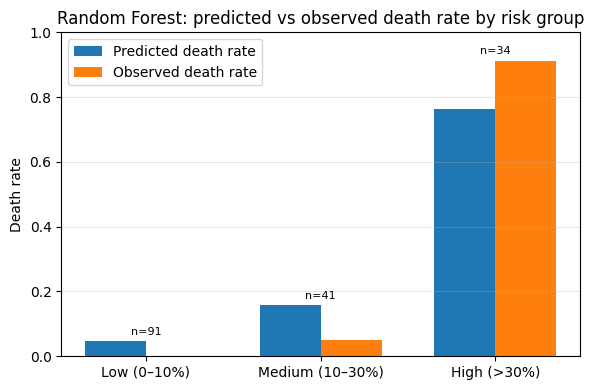

In [45]:
x = calib3["risk_group"].astype(str)
pred = calib3["pred_mean"]
obs  = calib3["obs_rate"]

plt.figure(figsize=(6,4))

w = 0.35
idx = np.arange(len(x))

plt.bar(idx - w/2, pred, width=w, label="Predicted death rate")
plt.bar(idx + w/2, obs,  width=w, label="Observed death rate")

for i, n in enumerate(calib3["n"]):
    plt.text(idx[i], max(pred[i], obs[i]) + 0.02, f"n={n}", ha="center", fontsize=8)

plt.xticks(idx, x, rotation=0)
plt.ylim(0, 1)
plt.ylabel("Death rate")
plt.title("Random Forest: predicted vs observed death rate by risk group")
plt.legend(loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("predicted_vs_observed.png", dpi=300, bbox_inches="tight")
plt.show()


6. Do deaths generally get higher predicted risk than survivors?

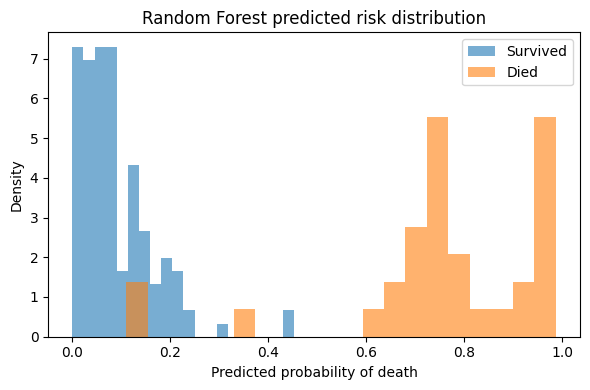

In [46]:
plt.figure(figsize=(6,4))

# survivors
plt.hist(
    y_proba_rf[y_test == 0],
    bins=20,
    alpha=0.6,
    label="Survived",
    density=True
)

# deaths
plt.hist(
    y_proba_rf[y_test == 1],
    bins=20,
    alpha=0.6,
    label="Died",
    density=True
)

plt.xlabel("Predicted probability of death")
plt.ylabel("Density")
plt.title("Random Forest predicted risk distribution")
plt.legend()
plt.tight_layout()
plt.savefig("predicted_risk_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


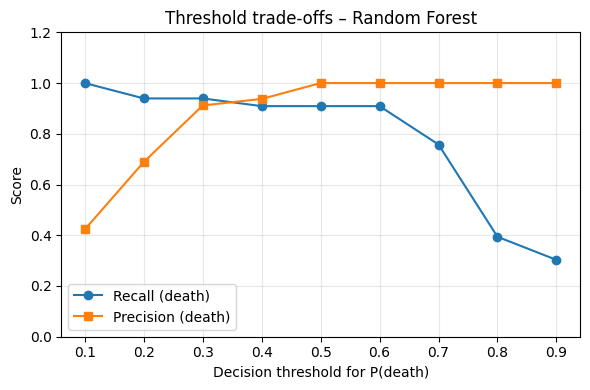

In [47]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.1, 0.9, 9)
precisions = []
recalls = []

for thr in thresholds:
    y_hat_thr = (y_proba_rf >= thr).astype(int)
    precisions.append(precision_score(y_test, y_hat_thr, pos_label=1))
    recalls.append(recall_score(y_test, y_hat_thr, pos_label=1))

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls,   marker="o", label="Recall (death)")
plt.plot(thresholds, precisions,marker="s", label="Precision (death)")
plt.xlabel("Decision threshold for P(death)")
plt.ylabel("Score")
plt.ylim(0, 1.2)
plt.title("Threshold trade-offs – Random Forest")
plt.grid(alpha=0.3)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("threshold_tradeoffs.png", dpi=300, bbox_inches="tight")
plt.show()
